In [1]:
import sys
sys.path.append('../')
from dataset import *
from data_aug import *
import tensorflow as tf
from comparison_model import *
from utils import *
from ranking_model import *

import random
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout, Subtract, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
image1_array, image2_array, labels = load_data("Mapillary/mapillary_training_dataaug_contrast/")
batch_size = 64

train_generator, valid_generator, test_generator, train_size, valid_size = prepare_dataset_generators(image1_array, image2_array, labels, batch_size, "comparison")

train_steps_per_epoch = train_size // batch_size
valid_steps_per_epoch = valid_size // batch_size

In [ ]:
def comparison_siamese_model(input_shape):
    """Create a siamese model for image comparison using VGG19 as base model.

    Args:
        input_shape (tuple): Shape of the input images.
    Returns:
        keras.models.Model: The compiled siamese model.
    """
    base_model = EfficientNetB0(include_top=False, weights='imagenet')
    
    for layer in base_model.layers[:-200]:
        layer.trainable=False

    # Create inputs for pairs of images
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)

    # Get embeddings of the images using the shared VGG19 model
    output_1 = base_model(input_1)
    output_2 = base_model(input_2)

    concat = concatenate([output_1, output_2])

    # Classification layer to predict similarity
    flatten = Flatten()(concat)
    x = Conv2D(32, (3, 3), activation="tanh", padding='same')(concat)
    x = Dropout(0.3)(x)
    x = Conv2D(32, (3, 3), activation="tanh", padding='same')(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    output = Dense(2, activation='sigmoid')(x)

    # Create the complete siamese model
    siamese_model = Model(inputs=[input_1, input_2], outputs=output)

    # Compile the model with the provided hyperparameters
    siamese_model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-05, decay=0.001), metrics=['accuracy'])

    # Print model summary
    siamese_model.summary()

    return siamese_model

siamese_model = comparison_siamese_model((224,224,3))
siamese_model.summary()

In [ ]:
history = siamese_model.fit(train_generator,
          steps_per_epoch=train_steps_per_epoch,
          epochs=100,
          validation_data=valid_generator,
          validation_steps=valid_steps_per_epoch)

In [ ]:
plot_accuracy(history)
plot_loss(history)
siamese_model.save("siamese.h5")

In [2]:
image1_array, image2_array, labels = load_data("Mapillary/mapillary_training_dataaug_contrast/")
batch_size = 64

train_generator, valid_generator, test_generator, train_size, valid_size = prepare_dataset_generators(image1_array, image2_array, labels, batch_size, "ranking")

train_steps_per_epoch = train_size // batch_size
valid_steps_per_epoch = valid_size // batch_size

In [6]:
def create_ranking_network(img_size):
    """
    Create ranking network which give a score to an image.

    :param img_size: size of input images during training
    :type img_size: tuple(int)
    :return: ranking network model
    :rtype: keras.Model
    """
    # Create feature extractor from VGG19
    feature_extractor = EfficientNetB0(include_top=False, weights='imagenet')
    for layer in feature_extractor.layers[:-200]:
        layer.trainable = False

    # Add dense layers on top of the feature extractor
    inp = Input(shape=(img_size, img_size, 3), name='input_image')
    base = feature_extractor(inp)
    base = Flatten(name='Flatten')(base)

    # Block 1
    base = Dense(32, activation='sigmoid', name='Dense_1')(base)
    base = BatchNormalization(name='BN1')(base)
    base = Dropout(0.2, name='Drop_1')(base)

    # Block 2
    base = Dense(32, activation='sigmoid', name='Dense_2')(base)
    base = BatchNormalization(name='BN2')(base)
    base = Dropout(0.2, name='Drop_2')(base)

    # Final dense
    base = Dense(1, name="Dense_Output")(base)
    base_network = Model(inp, base, name='Scoring_model')
    return base_network


def create_meta_network(img_size, weights=None):
    """
    Create meta network which is used to to teach the ranking network.

    :param img_size: dimension of input images during training.
    :type img_size: tuple(int)
    :param weights: path to the weights use for initialization
    :type weights: str
    :return: meta network model
    :rtype: keras.Model
    """

    # Create the two input branches
    input_left = Input(shape=(img_size, img_size, 3), name='left_input')
    input_right = Input(shape=(img_size, img_size, 3), name='right_input')
    base_network = create_ranking_network(img_size)
    left_score = base_network(input_left)
    right_score = base_network(input_right)

    # Subtract scores
    diff = Subtract()([left_score, right_score])

    # Pass difference through sigmoid function.
    prob = Activation("sigmoid", name="Activation_sigmoid")(diff)
    model = Model(inputs=[input_left, input_right], outputs= prob, name="Meta_Model")

    if weights:
        print('Loading weights ...')
        model.load_weights(weights)

    model.compile(optimizer=RMSprop(learning_rate=0.0001, decay=1e-05), loss="binary_crossentropy", metrics=['accuracy'])

    return model

meta_model = create_meta_network(224)

In [7]:
history = meta_model.fit(train_generator,
          steps_per_epoch=train_steps_per_epoch,
          epochs=100,
          validation_data=valid_generator,
          validation_steps=valid_steps_per_epoch)

Epoch 1/100
171/171 [==============================] - 106s 568ms/step - loss: 0.6588 - accuracy: 0.6938 - val_loss: 0.6592 - val_accuracy: 0.6116
Epoch 2/100
171/171 [==============================] - 86s 500ms/step - loss: 0.5404 - accuracy: 0.7509 - val_loss: 0.6673 - val_accuracy: 0.6006
Epoch 3/100
171/171 [==============================] - 85s 500ms/step - loss: 0.4481 - accuracy: 0.8016 - val_loss: 0.6122 - val_accuracy: 0.6782
Epoch 4/100
171/171 [==============================] - 85s 498ms/step - loss: 0.3610 - accuracy: 0.8460 - val_loss: 0.6624 - val_accuracy: 0.6127
Epoch 5/100
171/171 [==============================] - 85s 497ms/step - loss: 0.3147 - accuracy: 0.8658 - val_loss: 0.5321 - val_accuracy: 0.7459
Epoch 6/100
171/171 [==============================] - 85s 496ms/step - loss: 0.2517 - accuracy: 0.8939 - val_loss: 0.6302 - val_accuracy: 0.7319
Epoch 7/100
171/171 [==============================] - 85s 497ms/step - loss: 0.2216 - accuracy: 0.9112 - val_loss: 0.4142 

c:\anaconda\envs\tqdm\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


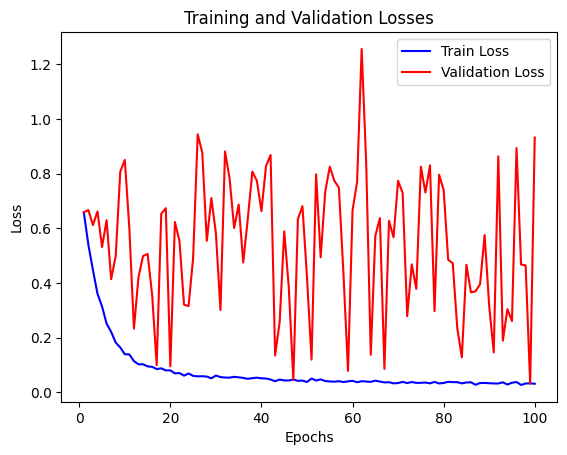

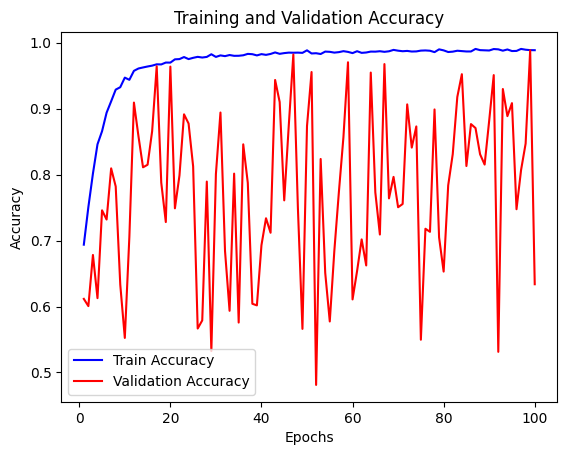

In [8]:
meta_model.save("meta_model_weight.h5")
ranking_model = meta_model.get_layer('Scoring_model')
ranking_model.save_weights('ranking_model_weights.h5')
plot_loss(history)
plot_accuracy(history)